# ASTR 3800

## Final Project

### Ravin Chowdhury

## Abstract

The Laser Interferometer Gravitational-Wave Observatory, or LIGO is designed to detect gravitational wave strains from binary compact object systems. In this study, we will begin by looking at the demographics of merger events detected by LIGO. Next, we will be look into the physics of the mergers by comparting initial and final masses of detected systems in order to determine the gravitational wave luminosities. Finally, I will consider a neutron star with a small bump of radius $10~\text{cm}$ and analyze the gravitational waves generated by it, along with the its luminosity.

## Introduction

Gravitational waves are transeverse waves in spacetime predicted by the general theory of relativity. They are the mass analogues to electromagnetic waves produced by moving charges, also moving at the speed of light, but much smaller in magnitude due to the size of the gravitational constant, $G$. While any moving mass-charge would produce gravitational waves, the largest gravitational waves, and those detectable by us on Earth, are generally those prodced in mergers of compact objects, since their revolutions angular speeds can reach extreme values [1].

LIGO is an ground based gravitational wave observatory usinng two interferometer-based detectors. These interferometers consist two $4~\text{km}$ long vaccuum tubes each at a $90$ degree angle, allowing the measurment of a difference of $1/10000^\text{th}$ the width of proton. Two movable mirrors, when deviated by the effect of gravitational wave strain on spacetime, change the lengths of one of the arms slightly and the resulting interefrence allows us the measure the size of the strain [1].

We begin by installing useful packages.

In [1]:
# Importing useful packages
import math
import numpy as np
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
from scipy.stats import pearsonr
import h5py
import json

import astropy.constants as co
import astropy.units as u

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use('default')
plt.rcParams.update({'font.size': 18})  # bigger font

<hr>

## 1 Ligo Signal Detection Demo

Tutorial 12 completed and submitted.

<hr>

## 2 Event Demographics

For this section, we visit the LIGO event list at [2] to download all available events as a `.csv` file.

In [2]:
# Reading events as Pandas dataframe
eventsDF = pd.read_csv('LIGO_events.csv')

print(f'Dataframe has {len(eventsDF.columns)} columns and {len(eventsDF)} events.')

# Display head
eventsDF.head()

Dataframe has 43 columns and 93 events.


,id,commonName,version,catalog.shortName,GPS,reference,jsonurl,mass_1_source,mass_1_source_lower,mass_1_source_upper,...,redshift_upper,far,far_lower,far_upper,p_astro,p_astro_lower,p_astro_upper,final_mass_source,final_mass_source_lower,final_mass_source_upper
0,GW150914-v3,GW150914,3,GWTC-1-confident,1.126259e+09,https://doi.org/10.7935/82H3-HH23,https://www.gw-openscience.org/eventapi/json/G...,35.6,-3.1,4.7,...,0.03,1.000000e-07,NaN,NaN,1.0,NaN,NaN,63.1,-3.0,3.4
1,GW151012-v3,GW151012,3,GWTC-1-confident,1.128679e+09,https://doi.org/10.7935/82H3-HH23,https://www.gw-openscience.org/eventapi/json/G...,23.2,-5.5,14.9,...,0.09,7.920000e-03,NaN,NaN,1.0,NaN,NaN,35.6,-3.8,10.8
2,GW151226-v2,GW151226,2,GWTC-1-confident,1.135136e+09,https://doi.org/10.7935/82H3-HH23,https://www.gw-openscience.org/eventapi/json/G...,13.7,-3.2,8.8,...,0.04,1.000000e-07,NaN,NaN,1.0,NaN,NaN,20.5,-1.5,6.4
3,GW170104-v2,GW170104,2,GWTC-1-confident,1.167560e+09,https://doi.org/10.7935/82H3-HH23,https://www.gw-openscience.org/eventapi/json/G...,30.8,-5.6,7.3,...,0.08,1.000000e-07,NaN,NaN,1.0,NaN,NaN,48.9,-4.0,5.1
4,GW170608-v3,GW170608,3,GWTC-1-confident,1.180922e+09,https://doi.org/10.7935/82H3-HH23,https://www.gw-openscience.org/eventapi/json/G...,11.0,-1.7,5.5,...,0.02,1.000000e-07,NaN,NaN,1.0,NaN,NaN,17.8,-0.7,3.4


For future use, let's print all the column headers.

In [3]:
print(eventsDF.columns.values)

['id' 'commonName' 'version' 'catalog.shortName' 'GPS' 'reference'
 'jsonurl' 'mass_1_source' 'mass_1_source_lower' 'mass_1_source_upper'
 'mass_2_source' 'mass_2_source_lower' 'mass_2_source_upper'
 'network_matched_filter_snr' 'network_matched_filter_snr_lower'
 'network_matched_filter_snr_upper' 'luminosity_distance'
 'luminosity_distance_lower' 'luminosity_distance_upper' 'chi_eff'
 'chi_eff_lower' 'chi_eff_upper' 'total_mass_source'
 'total_mass_source_lower' 'total_mass_source_upper' 'chirp_mass_source'
 'chirp_mass_source_lower' 'chirp_mass_source_upper' 'chirp_mass'
 'chirp_mass_lower' 'chirp_mass_upper' 'redshift' 'redshift_lower'
 'redshift_upper' 'far' 'far_lower' 'far_upper' 'p_astro' 'p_astro_lower'
 'p_astro_upper' 'final_mass_source' 'final_mass_source_lower'
 'final_mass_source_upper']


Now we can try and figure out some statistics of the LIGO events.

### 1.

We begin by determining the distance limit (redshift limit) of LIGO. To do this we can access the redshifts of all events.

In [4]:
# Redshift of events
zs = eventsDF['redshift']

# Errors on redshifts
zsUpper = eventsDF['redshift_upper']
zsLower = eventsDF['redshift_lower']

# Index of max redshift
iZMax = np.where(zs == np.max(zs))[0][0]

# Max redshift
zMax = zs[iZMax]

# Errors on max redshift
zMaxErrU = zsUpper[iZMax]
zMaxErrL = zsLower[iZMax]

print(f'The maximum redshift of LIGO is z = {zMax}')
print(f'Errors on this redshift are {zMaxErrL}, +{zMaxErrU}.')

The maximum redshift of LIGO is z = 1.18
Errors on this redshift are -0.53, +0.73.


So the redshift limits for LIGO are around

$\boxed{z_{\text{max}} = 1.18^{+0.73}_{-0.53}}$

We can convert this maximum redshift to a distance using Hubble's law.

$z = \dfrac{v}{c}$

and

$v = H_{0}d$

$\implies z = \dfrac{H_{0} d}{c}$

$\therefore \boxed{d = \dfrac{c z}{H_{0}}}$

Propagating error on this, we get

$\sigma_{d} = \dfrac{c}{H_{0}} \sigma_{z}$

In [5]:
# Hubble's constant
H0 = 71 * (u.km/u.s/u.Mpc)

# Distance to furthest event
dMax = (co.c*zMax/H0).to('Gpc')

# Errors on distance to furthest event
dMaxErrL = (co.c*zMaxErrL/H0).to('Gpc')
dMaxErrU = (co.c*zMaxErrU/H0).to('Gpc')

print(f'The distance to the furthest event is {dMax:.2f}.')
print(f'Errors on this distance are {dMaxErrL:.2f}, +{dMaxErrU:.2f}.')

The distance to the furthest event is 4.98 Gpc.
Errors on this distance are -2.24 Gpc, +3.08 Gpc.


This gives us the max distance that LIGO can see an event

$\boxed{d_{\text{max}} = 4.98^{+3.08}_{-2.24}\,\text{Gpc}}$

### 2.

Now we can check if there is a correlation between the binary mass (sum of masses) and the distance to check if there is an analogue to Malmquist bias in LIGO detection. We begin by loading both columns for correlation.

In [6]:
# Distances to events
ds = (co.c*zs/H0).to_numpy()

# Binary masses
mTots = (eventsDF['mass_1_source']+eventsDF['mass_2_source']).to_numpy() * u.Msun

# Errors on binary masses
mTotsErrL = np.sqrt((eventsDF['mass_1_source_upper'].to_numpy())**2 + (eventsDF['mass_2_source_upper'].to_numpy())**2) * u.Msun
mTotsErrU = np.sqrt((eventsDF['mass_1_source_lower'].to_numpy())**2 + (eventsDF['mass_2_source_lower'].to_numpy())**2) * u.Msun
mTotsErrs = np.array([mTotsErrL, mTotsErrU])

Now we can plot these to visually check for correlation.

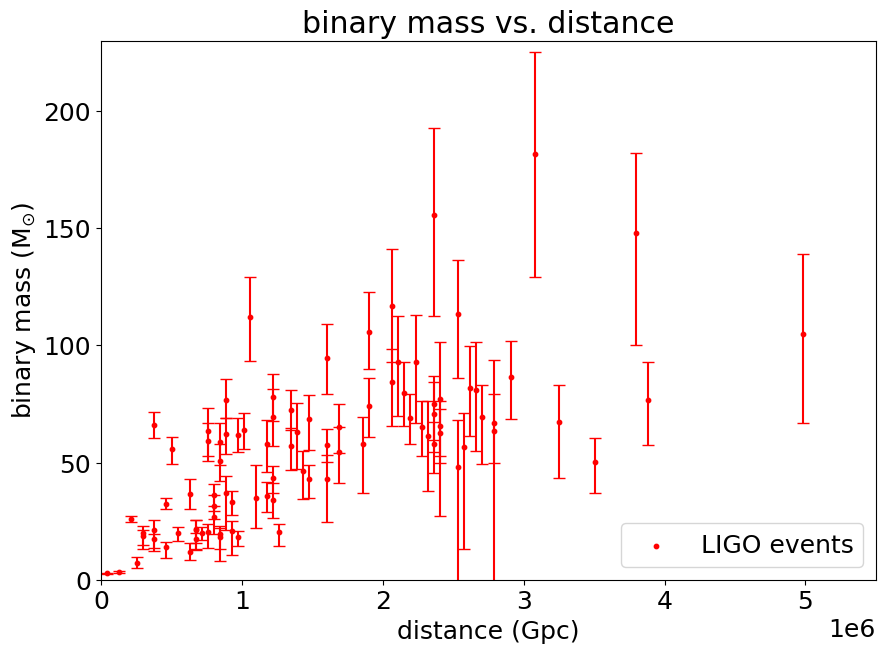

In [7]:
# Change figure plot size
plt.figure(figsize=(10, 7))
# Plot datapoints
plt.scatter(ds, mTots, color='r', s=10, label='LIGO events')
plt.errorbar(ds, mTots.value, color='r', yerr=mTotsErrs, linestyle='', capsize=4)
# Change axes limits
plt.xlim(0, 5.5e6); plt.ylim(0, 230)
# Add axes labels
plt.xlabel('distance (Gpc)'); plt.ylabel('binary mass (M$_{\odot}$)')
# Add figure title
plt.title('binary mass vs. distance'); plt.legend(loc='lower right')
plt.show()

Clearly, some correlation can be seen between the binary mass of an event and the distance to the event. To check this, I will be using the functions written in Tutorial 08.

In [8]:
# Function to find covariance
def sigmaCov(xs, ys):
    # Length of arrays
    N = len(xs)
    # Means of arrays
    xMean = np.mean(xs)
    yMean = np.mean(ys)
    # Return covariance
    return np.sum((xs-xMean)*(ys-yMean))/N

# Function to find correlation statistic
def corrStat(xs, ys):
    # Covariance
    sig = sigmaCov(xs, ys)
    # Standard deviations of both datasets
    sigX = np.std(xs)
    sigY = np.std(ys)
    # Return correlation statistic
    return sig/(sigX*sigY)

Now we can find the correlation between the two measurements.

In [9]:
# Obtain locations of NaN values
nanMask = np.logical_not(np.logical_or(np.isnan(ds), np.isnan(mTots)))

# Remove NaN values from both arrays
dsMasked = ds[nanMask]
mTotsMasked = mTots[nanMask]

# Correlation statistic for binary mass and distance
rMD = corrStat(dsMasked, mTotsMasked)
_, pval = pearsonr(dsMasked, mTotsMasked)

print(f'Binary mass and and distance have a correlation score of {rMD:.3f}.')
print(f'The probability of this correlation by chance is {pval*100:.3g}%.')

Binary mass and and distance have a correlation score of 0.681.
The probability of this correlation by chance is 1.59e-11%.


A score of $0$ would indicate no correlation while a score of $1$ would perfect correlation. Clearly, some correlation between the two exists. Checking the probability of getting this correlation by chance, we see that it is miniscule ($1.59\times{10^{-11}}\%$). Thus this is a real corrrelation.

### 3.

Next, we can try to asses the average mass fraction that is converted to gravitational waves.

This mass fraction is defined as

$f_{m} = \dfrac{\Delta m}{m_{1}+m_{2}}$

where $m_{1}+m_{2} = m_{\text{tot}}$.

Error on this is propagated to give

$\sigma_{f_{m}}^2 = \left(\dfrac{\partial f_{m}}{\partial m_{\text{tot}}}\right)^2 \sigma_{m_{\text{tot}}}^2 + \left(\dfrac{\partial f_{m}}{\partial \Delta m}\right)^2 \sigma_{\Delta m}^2$

with the required derivatives

$\dfrac{\partial f_{m}}{\partial m_{\text{tot}}} = -\dfrac{\Delta m}{m_{\text{tot}}^2}$

and

$\dfrac{\partial f_{m}}{\partial \Delta m} = \dfrac{1}{m_{\text{tot}}}$

In [10]:
# Final masses after merger
fMasses = eventsDF['final_mass_source'].to_numpy() * u.Msun
# Errors on final masses after merger
fMsErrL = eventsDF['final_mass_source_lower'].to_numpy() * u.Msun
fMsErrU = eventsDF['final_mass_source_upper'].to_numpy() * u.Msun

# Mask with NaN values
nanMask1 = np.logical_or(np.isnan(fMasses), np.isnan(fMsErrL))
nanMask2 = np.logical_or(nanMask1, np.isnan(fMsErrU))
nanMask = np.logical_not(nanMask2)

# Mass radiated as gravitational waves
deltaMs = mTots-fMasses
# Errors on masses radiated as gravitational waves
deltaMErrL = np.sqrt(mTotsErrL**2 + fMsErrL**2)
deltaMErrU = np.sqrt(mTotsErrU**2 + fMsErrU**2)

# Mass fractions radiated
mRads = (deltaMs/mTots).decompose()

# Partials for error
d1 = -deltaMs/(mTots**2)
d2 = 1/mTots

In [11]:
# Errors on mass fractions radiated
mRadErrL = np.sqrt((d1*mTotsErrL)**2 + (d2*deltaMErrL)**2)[nanMask]
mRadErrU = np.sqrt((d1*mTotsErrU)**2 + (d2*deltaMErrU)**2)[nanMask]

# Removing NaN values
mRads = mRads[nanMask]

# Average radiated mass fraction
mRadAvg = np.mean(mRads)

# Errors on average radiated mass fraction
mRadAvgErrL = np.sqrt(np.sum(mRadErrL**2)/(len(mRadErrL)-1))
mRadAvgErrU = np.sqrt(np.sum(mRadErrU**2)/(len(mRadErrU)-1))

# Standard deviation in radiated mass fractions
mRadStd = np.std(mRads)

print(f'The average radiated mass fraction is {mRadAvg:.4f}.')
print(f'Errors on this value are -{mRadAvgErrL:.4f}, +{mRadAvgErrU:.4f}.')

The average radiated mass fraction is 0.0392.
Errors on this value are -0.3729, +0.3458.


So, on average $0.039$ or $3.9\%$ of the binary systems mass is radiated during the merger with a spread of $-0.37$ $+0.35$.

$f_{m} = 0.039^{+3.5}_{-0.37}$

### 4.

Now we can calculate the mass-energy luminosities of the mergers in units of $L_{\odot}$ using Einstein's relation $E = m c^2$.

I will assume a typical merger duration of $0.05\,$seconds.

In [12]:
# Typical duration of a LIGO merger
tau = 0.05 * u.s

# Energies radiated as gravitational waves
ERads = deltaMs * (co.c**2)
# Errors on energy radiated
ERadErrsL = deltaMErrL * (co.c**2)
ERadErrsU = deltaMErrU * (co.c**2)

# Average luminosities of mergers
Ls = (ERads/tau).to(u.Lsun)
# Errors on luminosities
LErrsL = np.mean((ERadErrsL[nanMask]/tau).to(u.Lsun))/np.sqrt(len(ERads)-1)
LErrsU = np.mean((ERadErrsU[nanMask]/tau).to(u.Lsun))/np.sqrt(len(ERads)-1)

Now we can plot the luminosities of the mergers.

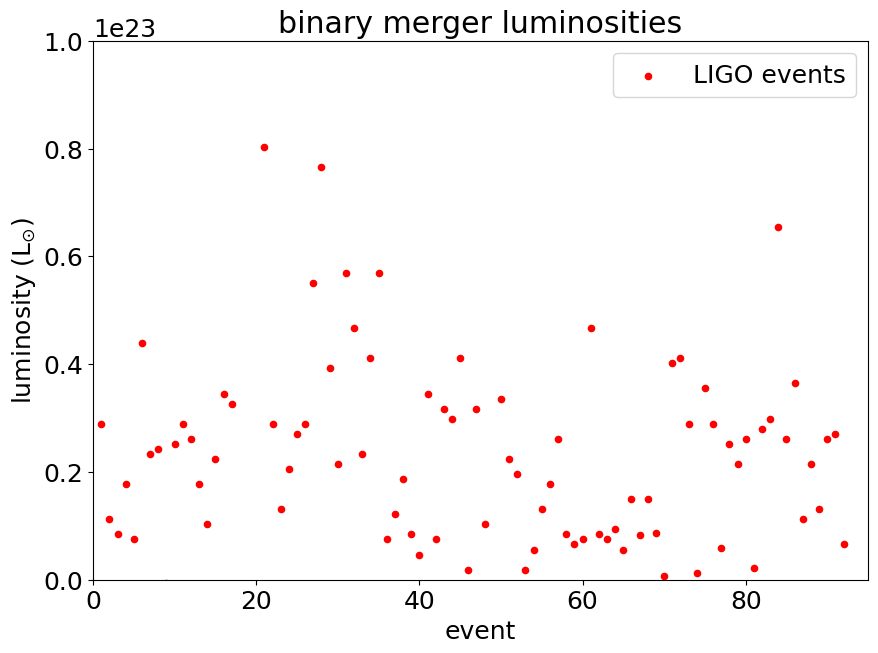

In [13]:
# Change figure plot size
plt.figure(figsize=(10, 7))
# Plot datapoints
plt.scatter(np.arange(len(Ls))+1, Ls.value, color='r', label='LIGO events', s=20)

# Change axes limits
plt.xlim(0, 95)
plt.ylim(0, 1e23)

# Add axes labels
plt.xlabel('event')
plt.ylabel('luminosity (L$_{\odot}$)')

# Add figure title
plt.title('binary merger luminosities')

# Add plot legend
plt.legend(loc='upper right')

# Show plot
plt.show()

As visible from the plot, the luminosities vary wildy from near $10^{18}\,L_{\odot}$ all the way up to $4\times{}10^{20}\,L_{\odot}$. To quantify this spread, we can find the standard deviation of the luminosities.

In [14]:
# Removing NaN values
Ls = Ls[~np.isnan(Ls)]
# Mean value
LMean = np.mean(Ls)
# Spread of luminosities
LsStd = np.std(Ls)

print(f'Spead in luminosities: {LMean:.3g} ± {LsStd:.3g}.')
print(f'Errors: -{LErrsL:.3g}, +{LErrsU:.3g}.')

Spead in luminosities: 2.26e+22 solLum ± 1.81e+22 solLum.
Errors: -1.68e+22 solLum, +1.63e+22 solLum.


So the spread in luminosities of the merger events is $\pm$ $1.81\times{}10^{22}\,L_{\odot}$.

Using error propagation instead:

$L = 2.26_{-1.68}^{+1.63}\times{10^{22}}~\text{L}_{\odot}$

Next, we can try to figure out which merger is the most luminous.

In [15]:
# Highest luminosity
LMax = np.max(Ls)

print(f'The highest luminosity is {LMax:.3g}.')

The highest luminosity is 8.03e+22 solLum.


So the highest luminosity is $8.03\times{}10^{22}\,L_{\odot}$ which is a hundred million times more luminous than J224607.57−052635.0, the most luminous known galaxy with a luminosity of around $3.5\times{}10^{14}\,L_{\odot}$.

### 5.

Next, let's look at the statistics of the mass ratio of the binary mergers. I will define this as

$r_{M} = \dfrac{m_{1}}{m_{2}}$.

In the LIGO data, $m_{1} > m_{2}$, so this will allow us to compare the mass ratios.

In [16]:
# Mass ratio of binaries
rM = (eventsDF['mass_1_source']/eventsDF['mass_2_source']).to_numpy()

# Removing NaN values
rM = rM[~np.isnan(rM)]

# Mean mass ratio
rMMean = np.mean(rM)

# Standard deviation in mass ratio
rMStd = np.std(rM)

# Minimum mass ratio
rMMin = np.min(rM)

# Maximum mass ratio
rMMax = np.max(rM)

print(f'The distribution in mass ratios if {rMMean:.2f} ± {rMStd:.2f}.')
print(f'\nThe smallest mass ratio is {rMMin:.2f}.')
print(f'The largest mass ratio is {rMMax:.2f}.')

The distribution in mass ratios if 2.17 ± 2.88.

The smallest mass ratio is 1.15.
The largest mass ratio is 26.58.


So the average mass ratio is $2.17$ with a standard deviation of $\pm$ $2.88$. The smallest mass ratio detected was $1.15$ and the largest $26.58$.

## 3 Standard Sirens

Gravitational wave signals can be used as standard sirens since we can find both the gravitatioinal wave flux from the source, and the masses of the bodies involved. An analogue to the luminosity-distance equation

$D_{L} = \sqrt{\dfrac{L}{4 \pi F}}$

can be used.

Similar to other standard sirens, we can use Hubble's Law to obtain estimates for the Hubble Constant.

$H_{0} = \dfrac{c z}{D_{L}}$

One limitation of this method is the identification of locations of gravitational wave sources. Sources frequently are hard to localise to a single point in the sky, and only one known event `GW170817` has been localised to its host galaxy since the event was visible with optical telescopes.

### 1.

Let's begin by finding the luminosity distance of this event.

In [17]:
# Index of event
iE = np.where(eventsDF['commonName'] == 'GW170817')[0][0]

# Luminosity distance of event
lDGW = eventsDF['luminosity_distance'][iE] * u.Mpc

# Lower errorbar on luminosity distance of event
lDGWLowErr = eventsDF['luminosity_distance_lower'][iE] * u.Mpc

# Upper errorbar on luminosity distance of event
lDGWUpErr = eventsDF['luminosity_distance_upper'][iE] * u.Mpc

print(f'The luminosity distance of GW170817 is {lDGW}.')
print(f'Error on this value is {lDGWLowErr} (lower) and {lDGWUpErr} (upper).')

The luminosity distance of GW170817 is 40.0 Mpc.
Error on this value is -15.0 Mpc (lower) and 7.0 Mpc (upper).


### 2.

Let's obtain an estimate for the Hubble's constant using an observed recession velocity for the host galaxy of the event.

$v = 3017 \pm 166\,\text{km}/\text{s}$

The relevant formula is

$H_{0} = \dfrac{v}{D_{L}}$

In [18]:
# Recession velocity of host
vE = 3017 * (u.km/u.s)

# Error on recession velocity of host
vEErr = 166 * (u.km/u.s)

# Hubble's constant estimate
H0_1 = (vE/lDGW).to(u.km/u.s/u.Mpc)

print(f"Estimate for Hubble's constant: {H0_1:.1f}")

Estimate for Hubble's constant: 75.4 km / (Mpc s)


So we get the value for Hubble's constant

$H_{0} = 75.4\,\text{km}/\text{s}/\text{Mpc}$

### 3.

Now we can add errors on this calculated value of Hubble's constant.

We can propagate error on the Hubble's constant.

$\sigma_{H_0}^2=\left(\dfrac{\partial H_0}{\partial v}\right)^2\sigma_{v}^2 + \left(\dfrac{\partial H_0}{\partial D_L}\right)^2\sigma_{D_L}^2$

Where

$\dfrac{\partial H_0}{\partial v}=\dfrac{1}{D_L}$

$\dfrac{\partial H_0}{\partial D_L}=-\dfrac{v}{D_L^2}$

In [19]:
# Derivatives for error propagation
d1 = 1/lDGW
d2 = -vE/(lDGW**2)

# Lower error on Hubble's constant
H0_1LowErr = np.sqrt((d1**2)*(vEErr**2) + (d2**2)*(lDGWLowErr**2))

# Upper error on Hubble's constant
H0_1UpErr = np.sqrt((d1**2)*(vEErr**2) + (d2**2)*(lDGWUpErr**2))

print(f"Estimate for Hubble's constant: {H0_1:.1f}")
print(f'Errors: -{H0_1LowErr:.1f} (lower), +{H0_1UpErr:.1f} (upper)')

Estimate for Hubble's constant: 75.4 km / (Mpc s)
Errors: -28.6 km / (Mpc s) (lower), +13.8 km / (Mpc s) (upper)


So using the merger GW170817, we get the estimate for Hubble's constant

$H_{0} = 75.4_{-28.6}^{+13.8}\,\text{km}/\text{s}/\text{Mpc}$

This value, while uncertain, is in agreement with both the $\Lambda\text{CDM}$ model and direct measurement.

$H_{0, \Lambda \text{CDM}} = 67.78_{-0.87}^{+0.91}\,\text{km}/\text{s}/\text{Mpc}$

$H_{0, \text{HST}} = 74.03 \pm 1.42\,\text{km}/\text{s}/\text{Mpc}$

### 4.

Currently, our error on Hubble's constant is

$H_{0} = 75.4_{-28.6}^{+13.8}\,\text{km}/\text{s}/\text{Mpc}$

Using only the larger error bar ($-28.6\,\text{km}/\text{s}/\text{Mpc}$), this represents an error of about $38\%$. Taking more measurements, we can reduce this uncertainty in the standard deviation of the mean.

$\sigma_{\mu} = \dfrac{\sigma}{\sqrt{N}}$

$\implies \dfrac{\sigma_{\mu}}{\mu} = \dfrac{\sigma}{\mu} \cdot \dfrac{1}{\sqrt{N}}$

$\implies \sqrt{N} = \dfrac{\sigma}{\mu} \cdot \dfrac{\mu}{\sigma_{\mu}}$

$\therefore \boxed{N = \left(\dfrac{\sigma}{\mu} \cdot \dfrac{\mu}{\sigma_{\mu}}\right)^2}$

or

$\boxed{N = \left(\dfrac{\text{single measurment error}}{\text{desired error}}\right)^2}$

In [20]:
# Number of measurements for error of 10%
N_10 = np.ceil(((H0_1LowErr/H0_1)/0.1)**2)

# Number of measurements for error of 1%
N_1 = np.ceil(((H0_1LowErr/H0_1)/0.01)**2)

print(f"Current error on Hubble's constant is {(H0_1LowErr/H0_1)*100:.3g}%")
print(f'{N_10:.0f} such measurements will get the error below 10%.')
print(f'{N_1:.0f} such measurements will get the error below 1%.')

Current error on Hubble's constant is 37.9%
15 such measurements will get the error below 10%.
1437 such measurements will get the error below 1%.


So, using $15$ measurements will get the error on our Hubble's constant measurement to below $10\%$.

Similarly, $1437$ measurements will get the error below $1\%$.

## 4 Your Own Exploration and Analysis

### 1. *Write down a question or questions that you would like to answer.*

I will be answering question 13:

>Theory: Would a mountain on a rotating spherical body make gravitational waves? Where would the energy come from? What would the signal look like for a 10 cm high mountain on a neutron star?

### 2. *Can the answer to your question be quantified using data or theoretical calculations?*

To answer this question qualitatively, we can try and model this system mathematically and see if it produces gravitational waves. If yes, we can look at the strains it would produce, and the signal that LIGO would detect.

### 3. *Attempt to answer your question. In the process, always make plots and support conclusions quantitatively. Cite your sources*

I will start by making a model for the neutron star. Let us consider the mountain on the neutron star to be a mass that can be approximated to be a smaller sphere of radius $10~\text{cm}$ touching the surface of the neutron star. I will be considering a neutron star of radius $10~\text{km}$ which would approximately be a solar mass. I will also consider the case with the mountain on the equator of the neutron star to make calculations simpler.

Using this model, one can approach this system as one would a binary system orbiting around their collective center of mass.

Neutron stars typically have rotation periods from $1.4~\text{ms}$ to $30~\text{s}$. For simplicity I will be considering our star to have a period of $1~\text{s}$ [3].

Also since the strain from this body will be extremely small, we can consider it to be very close to us. I will use the distance of $1~\text{pc}$, but as we will see strain falls inversely with distance so results for other distances can be extrapolated.

We begin by calculating useful parameters, such as the center of mass of the system. We can also compare our neutron star to different masses to get some insight.

In [21]:
# Distance to neutron star
r = 1 * u.pc

# Period of neutron star rotation
tau = 1 * u.s

# Density of a neutron star
rho = 4.5e17 * (u.kg/(u.m**3))

# Radius of neutron star
R1 = 10 * u.km
# Height of mountain: we will approximate this by considering 
# an attached sphere of this radius
R2 = 10 * u.cm

# Mass of neutron star
m1 = ((4/3)*np.pi*rho*R1**3).to(u.kg)
# Mass of mountain
m2 = ((4/3)*np.pi*rho*R2**3).to(u.kg)

# Just for fun, mass of mount Everest
mME = 8.1e9 * u.kg

# Total mass
M = m1 + m2
# Reduced mass
mu = (m1*m2/M)

print(f'Mass of neutron star: {M:.3g}')
print(f'                  or: {M.to(u.Msun):.3g}')
print(f'\nMass of mountain: {m2:.3g}')
print(f'or {(m2/mME).decompose():.3g} times the mass of Mt. Everest.')
print(f'\nReduced mass: {mu:.3g}')

Mass of neutron star: 1.88e+30 kg
                  or: 0.948 solMass

Mass of mountain: 1.88e+15 kg
or 2.33e+05 times the mass of Mt. Everest.

Reduced mass: 1.88e+15 kg


In [22]:
# Distance between centers of star
# and mountain
Rsum = (R1 + R2).to(u.m)

# Using center of neutron star as x = 0
# finding center of mass of star-mountain
xbar = ((m1*0 * u.m + m2*Rsum)/M).to(u.m)

# Defining new coordinate system with
# center of mass at x = 0

# Distance of neutron star from center
# of mass
a1 = xbar
# Distance of mountain from center of mass
a2 = Rsum - xbar

print(f'\nThe center of the neutron star is {a1.to(u.pm):.3g} from the center of mass.')
print(f'The mountain is {a2.to(u.km):.3g} from the center of mass.')


The center of the neutron star is 10 pm from the center of mass.
The mountain is 10 km from the center of mass.


So our neutron star has a mass of $0.95$ solar masses which is very close to the mass of Sun despite being only $10~\text{km}$ in radius. Neutron stars are incredibly dense, so even the mountain which is only $10~\text{cm}$ in radius is still around $23\,000$ times the mass of mount Everest.

Moreover, the mountain is small enough compared to the neutron star that the center of mass is displaced by only $10~\text{pm}$ from the center of the neutron star. We can very safely approximate the neutron star to be at the center of mass, but I won't be making this approximation just so that we can try the result for differently-sized mountains.

Now we can use these values to obtain the equations of motion for the neutron star and mountain. I will use $1$ to denote the neutron star and $2$ to denote the mountain. Also let $t=0~\text{s}$ in our frame of reference denote the position where the neutron star is at $x_{1} = a_{1}$ and $y_{1} = 0$. The mountain will be opposite at $x_{2} = -a_{2}$ and $y_{2} = 0$. This frame of refernce is centered around their center of mass.

The required equations of motion are.

$x_{1} = a_{1} \cos{\Omega t}$

$y_{1} = a_{1} \sin{\Omega t}$

$x_{2} = -a_{2} \cos{\Omega t}$

$y_{2} = -a_{2} \sin{\Omega t}$

Let us visualise this motion through plots.

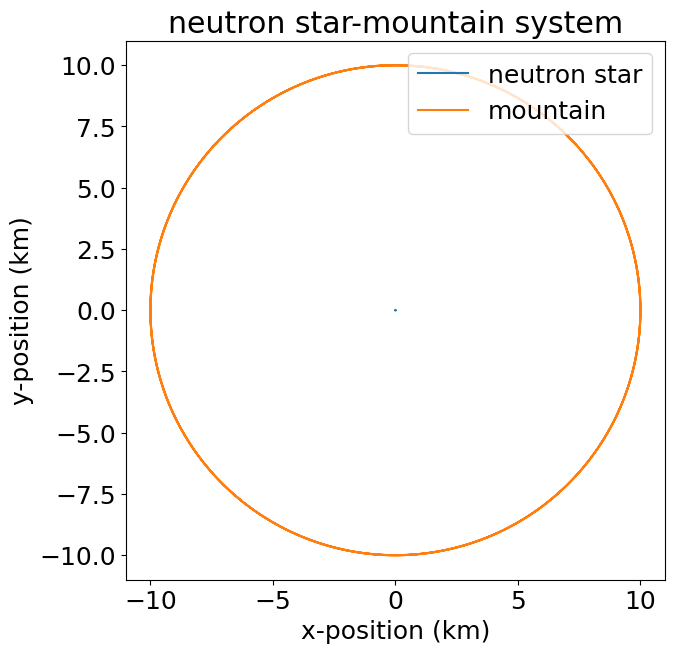

In [23]:
# Rotation frequency of neutron star
f = 1/tau; Omega = 2*np.pi*f * u.rad

# Start and end times
tStart = 0; tEnd = 3*(tau.to(u.s).value) # seconds
# Creating array of times
ts = np.linspace(tStart, tEnd, num=int(1e4)) * u.s
# Neutron star center coordinates
x1 = a1*np.cos(Omega * ts); y1 = a1*np.sin(Omega * ts)
# Mountain center coordinates
x2 = -a2*np.cos(Omega * ts); y2 = -a2*np.sin(Omega * ts)

# Creating figure
plt.figure(figsize=(7, 7))
# Plotting positions
plt.plot(x1.to(u.km), y1.to(u.km), label='neutron star')
plt.plot(x2.to(u.km), y2.to(u.km), label='mountain')
# Adding axes labels
plt.xlabel('x-position (km)'); plt.ylabel('y-position (km)')
# Adding figure title
plt.title('neutron star-mountain system')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='upper right')
plt.show()

Clearly, the motion of the neutron star is miniscule compared to the motion of the mountain! However, both trace out circular paths. This can also be seen as a position vs. time plot. Starting with the neutron star:

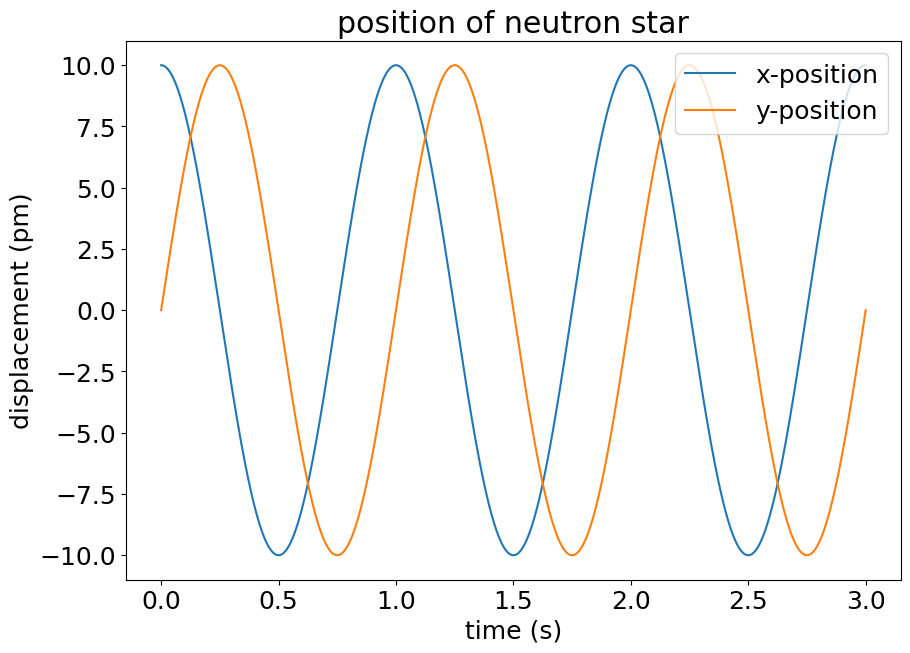

In [24]:
# Creating figure
plt.figure(figsize=(10, 7))
# Plotting positions
plt.plot(ts, x1.to(u.pm), label='x-position')
plt.plot(ts, y1.to(u.pm), label='y-position')
# Adding axes labels
plt.xlabel('time (s)')
plt.ylabel('displacement (pm)')
# Adding figure title
plt.title('position of neutron star')
# Adding legend
plt.legend(loc='upper right')
# Show plot
plt.show()

and then the mountain which lies radially opposite:

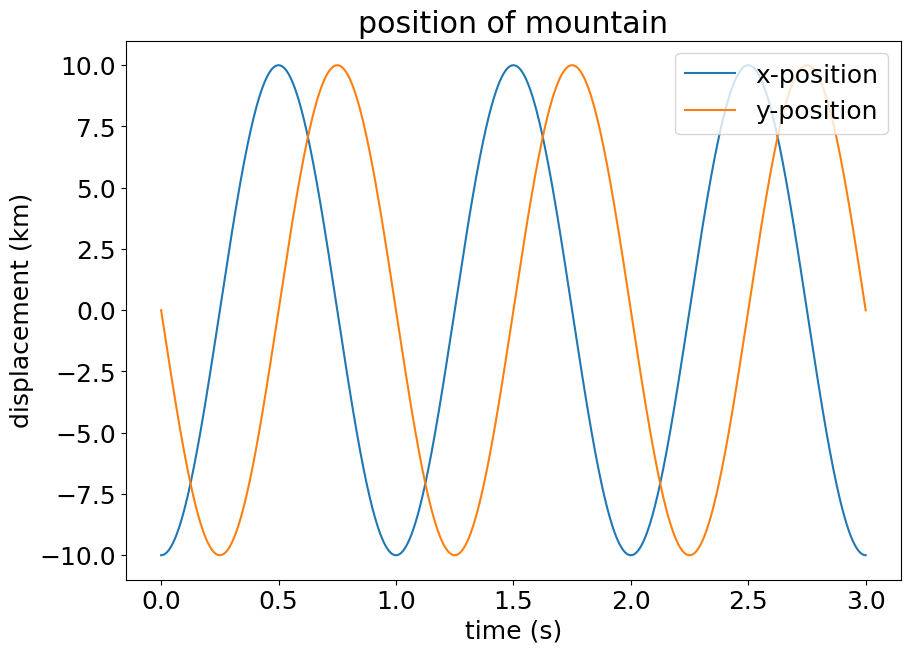

In [25]:
# Creating figure
plt.figure(figsize=(10, 7))
# Plotting positions
plt.plot(ts, x2.to(u.km), label='x-position')
plt.plot(ts, y2.to(u.km), label='y-position')
# Adding axes labels
plt.xlabel('time (s)')
plt.ylabel('displacement (km)')
# Adding figure title
plt.title('position of mountain')
# Adding legend
plt.legend(loc='upper right')
# Show plot
plt.show()

Now that we understand the motion, we can derive the gravitational wave strain of this system. We begin by finding the moment of inertia tensor of this system. The tensor is given by the expression

$\mathbf{I} = {\int_{V}} \rho\left(x, y, z\right)
\begin{bmatrix}
y^2 + z^2 & -x y & -x z \\
-x y & z^2 + x^2 & -y z \\
-x z & -y z & x^2 + y^2 \\
\end{bmatrix}
\,dx\,dy\,dz$.

For a sphere centered at the origin this gives,

$\mathbf{I} = \dfrac{2}{5} M R^2
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
\end{bmatrix}$

where the cross terms (non-principal terms) are zero due to the symmetry.

Now suppose we move the sphere to a position $\left(h, k, 0 \right)$ with respect to the center of rotation. THis changes the moment of inertia tensor in accordance with the parallel axis theorem:

For new position $\overrightarrow{r} = \left(r_{x}, r_{y}, r_{z} \right)$

$I_{ij}' = I_{ij} + M \left(\delta_{ij} r^2 - r_{i} r_{j}\right)$

but we have the following values

$r_{x} = h$

$r_{y} = k$

$r_{z} = 0$

and

$r = \sqrt{h^2 + k^2}$.

Thus,

$I_{xx}' = I_{xx} + M \left(\delta_{xx} \left(h^2 + k^2\right) - r_{x} r_{x}\right) = \boxed{M\left(\dfrac{2}{5} R^2 + k^2\right)}$

$I_{yy}' = I_{yy} + M \left(\delta_{yy} \left(h^2 + k^2\right) - r_{y} r_{y}\right) = \boxed{M\left(\dfrac{2}{5} R^2 + h^2\right)}$

$I_{zz}' = I_{zz} + M \left(\delta_{zz} \left(h^2 + k^2\right) - r_{z} r_{z}\right) = \boxed{M\left(\dfrac{2}{5} R^2 + h^2 + k^2\right)}$.

And the cross terms ($i \ne j$):

$I_{ij}' = -M r_{i} r_{j}$

Therefore

$I_{xy}' = -M r_{x} r_{y} = \boxed{-M h k}$

$I_{xz}' = -M r_{x} r_{z} = \boxed{0}$

$I_{yx}' = -M r_{y} r_{x} = \boxed{-M h k}$

$I_{yz}' = -M r_{y} r_{z} = \boxed{0}$

$I_{zx}' = -M r_{z} r_{x} = \boxed{0}$

$I_{zy}' = -M r_{z} r_{y} = \boxed{0}$

Combining these, we get the moment of inertia tensor

$\mathbf{I}' = M
\begin{bmatrix}
\dfrac{2}{5} R^2 + k^2 & -h k & 0 \\
-h k & \dfrac{2}{5} R^2 + h^2 & 0 \\
0 & 0 & \dfrac{2}{5} R^2 + h^2 + k^2 \\
\end{bmatrix}$

Hereafter, $\mathbf{I}_{ns}$ and $\mathbf{I}_{mn}$ will refer to the moment in inertia tensors for the neutron star and mountain respectively relative to the center of mass.

Next, since we know the positions of the bodies as a function of time, we can find the moment of inertia as a function of time.

$x_{1} = a_{1} \cos{\Omega t}$

$y_{1} = a_{1} \sin{\Omega t}$

$\mathbf{I}_{ns} = m_{1}
\begin{bmatrix}
\dfrac{2}{5} R_{1}^2 + \left(a_{1} \sin{\Omega t}\right)^2 & - \left(a_{1} \cos{\Omega t}\right) \left(a_{1} \sin{\Omega t}\right) & 0 \\
-\left(a_{1} \cos{\Omega t}\right) \left(a_{1} \sin{\Omega t}\right) & \dfrac{2}{5} R_{1}^2 + \left(a_{1} \cos{\Omega t}\right)^2 & 0 \\
0 & 0 & \dfrac{2}{5} R_{1}^2 + \left(a_{1} \cos{\Omega t}\right)^2 + \left(a_{1} \sin{\Omega t}\right)^2 \\
\end{bmatrix}$

$\implies \mathbf{I}_{ns} = m_{1}
\begin{bmatrix}
\dfrac{2}{5} R_{1}^2 + a_{1}^2 \sin^2{\Omega t} & - a_{1}^2 \sin{\Omega t} \cos{\Omega t} & 0 \\
-a_{1}^2 \sin{\Omega t} \cos{\Omega t} & \dfrac{2}{5} R_{1}^2 + a_{1}^2 \cos^2{\Omega t} & 0 \\
0 & 0 & \dfrac{2}{5} R_{1}^2 + a_{1}^2 \\
\end{bmatrix}$.

$\implies \mathbf{I}_{ns} = m_{1}
\begin{bmatrix}
\dfrac{2}{5} R_{1}^2 + \dfrac{1}{2}a_{1}^2 - \dfrac{1}{2}a_{1}^2 \cos{2 \Omega t} & - \dfrac{1}{2} a_{1}^2 \sin{2 \Omega t} & 0 \\
- \dfrac{1}{2} a_{1}^2 \sin{2 \Omega t} & \dfrac{2}{5} R_{1}^2 + \dfrac{1}{2}a_{1}^2 + \dfrac{1}{2}a_{1}^2 \cos{2 \Omega t} & 0 \\
0 & 0 & \dfrac{2}{5} R_{1}^2 + a_{1}^2 \\
\end{bmatrix}$.

For simplicity, we can write this as the sum of a time-independent and time dependent tensor.

$\mathbf{I}_{ns} = \mathbf{I}_{ns, ti} + \mathbf{I}_{ns, td}\left(t\right)$

We will be using only the time dependent part so let's write it down.

$\mathbf{I}_{ns, td} \left(t\right) = \dfrac{1}{2} m_{1} a_{1}^2
\begin{bmatrix}
- \cos{2 \Omega t} & - \sin{2 \Omega t} & 0 \\
- \sin{2 \Omega t} & \cos{2 \Omega t} & 0 \\
0 & 0 & 0 \\
\end{bmatrix}$

Finally, we will take the second time derivative of the inertia tensor.

$\therefore \boxed{\ddot{\mathbf{I}}_{ns}^{TT} \left(t\right) = 2 m_{1} a_{1}^2 \Omega^2
\begin{bmatrix}
\cos{2 \Omega t} & \sin{2 \Omega t} & 0 \\
\sin{2 \Omega t} & - \cos{2 \Omega t} & 0 \\
0 & 0 & 0 \\
\end{bmatrix}}$

By symmetry, we obtain the tensor for the mountain:

$x_{2} = -a_{2} \cos{\Omega t}$

$y_{2} = -a_{2} \sin{\Omega t}$

$\therefore \boxed{\ddot{\mathbf{I}}_{mn}^{TT} \left(t\right) = 2 m_{2} a_{2}^2 \Omega^2
\begin{bmatrix}
\cos{2 \Omega t} & \sin{2 \Omega t} & 0 \\
\sin{2 \Omega t} & - \cos{2 \Omega t} & 0 \\
0 & 0 & 0 \\
\end{bmatrix}}$

It can be noticed that the frequency of this tensor is now $2\Omega$ or twice the rotation frequency of the neutron star. This will show that the frequency of gravitational waves is twice the frequency of the periodic motion.

The strain tensor is defined by

$h_{ij}\left(t\right) = \dfrac{2 G}{c^4 r} \ddot{I}_{ij}^{TT} \left(t - r/c \right)$

(Obtained from [4])

Here, $t$ has been replaced by $t-r/c$ or reduced time to account for the space-time distance between the event and the observer. This gives us the two strain tensors for the neutron star and mountain

$\mathbf{h}_{ns}\left(t\right) = \dfrac{4 G m_{1} a_{1}^2 \Omega^2}{c^4 r} 
\begin{bmatrix}
\cos{2 \Omega (t-r/c)} & \sin{2 \Omega (t-r/c)} & 0 \\
\sin{2 \Omega (t-r/c)} & - \cos{2 \Omega (t-r/c)} & 0 \\
0 & 0 & 0 \\
\end{bmatrix}$

$\mathbf{h}_{mn}\left(t\right) = \dfrac{4 G m_{2} a_{2}^2 \Omega^2}{c^4 r} 
\begin{bmatrix}
\cos{2 \Omega (t-r/c)} & \sin{2 \Omega (t-r/c)} & 0 \\
\sin{2 \Omega (t-r/c)} & - \cos{2 \Omega (t-r/c)} & 0 \\
0 & 0 & 0 \\
\end{bmatrix}$

Thus the net strain tensor is given by

$\mathbf{h}_{tot}\left(t\right) = \mathbf{h}_{ns}\left(t\right) + \mathbf{h}_{mn}\left(t\right)$

$ = \boxed{\dfrac{4 G \left(m_{1} a_{1}^2 + m_{2} a_{2}^2\right) \Omega^2}{c^4 r}
\begin{bmatrix}
\cos{2 \Omega (t-r/c)} & \sin{2 \Omega (t-r/c)} & 0 \\
\sin{2 \Omega (t-r/c)} & - \cos{2 \Omega (t-r/c)} & 0 \\
0 & 0 & 0 \\
\end{bmatrix}}$

For an observer viewing this event along the z-axis, the amplitudes of the plus and cross radiated strains are given by [5]

$h_{+} = I_{xx} = \dfrac{4 G \left(m_{1} a_{1}^2 + m_{2} a_{2}^2\right) \Omega^2}{c^4 r}\cos{2 \Omega (t-r/c)}$

and

$h_{\times} = I_{xy} = \dfrac{4 G \left(m_{1} a_{1}^2 + m_{2} a_{2}^2\right) \Omega^2}{c^4 r}\sin{2 \Omega (t-r/c)}$

For an off-axis observer we can use the following rotation matrix to transform the strain tensor polarizations.

$\mathbf{R}\left(\iota\right) = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos{\iota} & \sin{\iota} \\
0 & -\sin{\iota} & \cos{\iota} \\
\end{bmatrix}$

where $\iota$ is the colatitude angle from the z-axis in polar coordinates (in radians).

Represented in the frame of the rotation matrix, the transformed strain tensor is given by

$\mathbf{h}\left(t\right) = \mathbf{R}\left(\iota\right) \cdot \mathbf{h}\left(t\right) \cdot \mathbf{R}^{T}\left(\iota\right)$

This gives us the new polarizations

$h_{+} = \dfrac{4 G \left(m_{1} a_{1}^2 + m_{2} a_{2}^2\right) \Omega^2}{c^4 r} \left( \dfrac{1 + \cos^2{\iota}}{2} \right) \cos{2 \Omega (t-r/c)}$

and

$h_{\times} = \dfrac{4 G \left(m_{1} a_{1}^2 + m_{2} a_{2}^2\right) \Omega^2}{c^4 r} \cos{\iota} \cdot \sin{2 \Omega (t-r/c)}$

This is the final required expression for strains. Now we can use this to calculate the strains that LIGO would measure!

In [26]:
# Moment of inertia constant
L0 = m1 * (a1**2) + m2 * (a2**2)
# Amplitude of strain
h0 = ((4 * co.G * L0 * (Omega/u.rad)**2)/((co.c**4) * r)).decompose()

print(f'Amplitude of strain: {h0:.3g}')

Amplitude of strain: 7.97e-36


This amplitude is tiny. For context, the historic LIGO detection in 2015 measured a strain of near $10^{-21}$. This is $10^{15}$ times smaller! The binary merger detected was a distance of $4\times{10^{8}}~\text{pc}$ from the detector compared to our $1~\text{pc}$.

Now let us look at the two polarizations of strain as a function of time for different viewing angles. We begin by viewing the event along the axis of rotation of the neutron star.

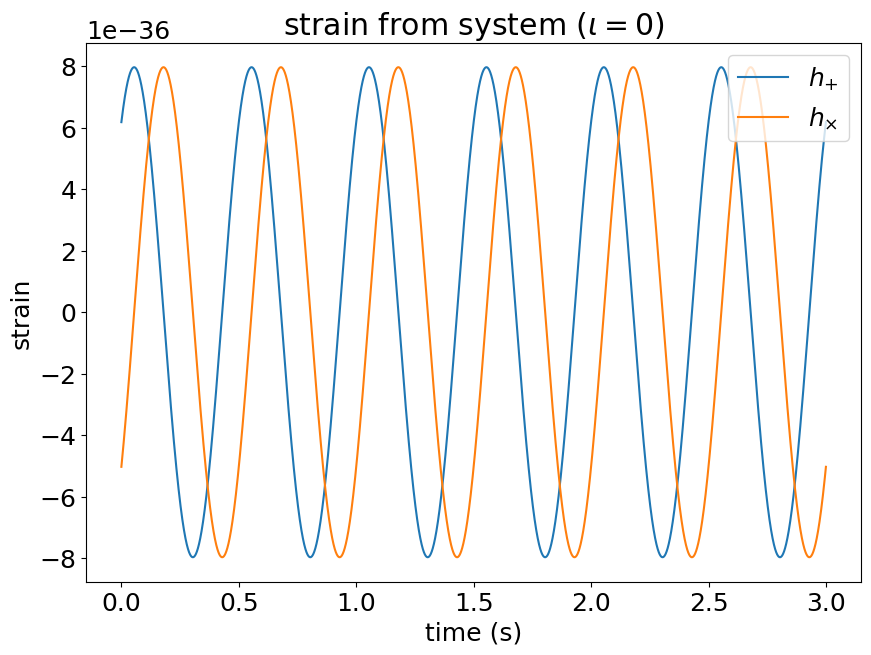

In [27]:
# Viewing angle
iota1 = 0 * u.rad

# List of plus polarized strains
hPlus1 = h0 * (1/2) * (1 + np.cos(iota1)**2) * np.cos(2 * Omega * (ts - r/co.c))
# List of cross polarized strains
hCross1 = h0 * np.cos(iota1) * np.sin(2 * Omega * (ts - r/co.c))

# Creating figure
plt.figure(figsize=(10, 7))
# Plotting strains
plt.plot(ts, hPlus1, label='$h_{+}$')
plt.plot(ts, hCross1, label=r'$h_{\times}$')
# Adding axes labels
plt.xlabel('time (s)'); plt.ylabel('strain')
# Adding figure title
plt.title('strain from system ($\iota = 0$)')
plt.legend(loc='upper right')
plt.show()

As can be seen from the above plot, viewing the event in this direction produces equal magnitudes for both polarizations at around $8\times{10^{-36}}$.

Next we can see what happens if instead we are viewing the event from within the plane of rotation of the neutron star, similar to viewing an eclipsing binary.

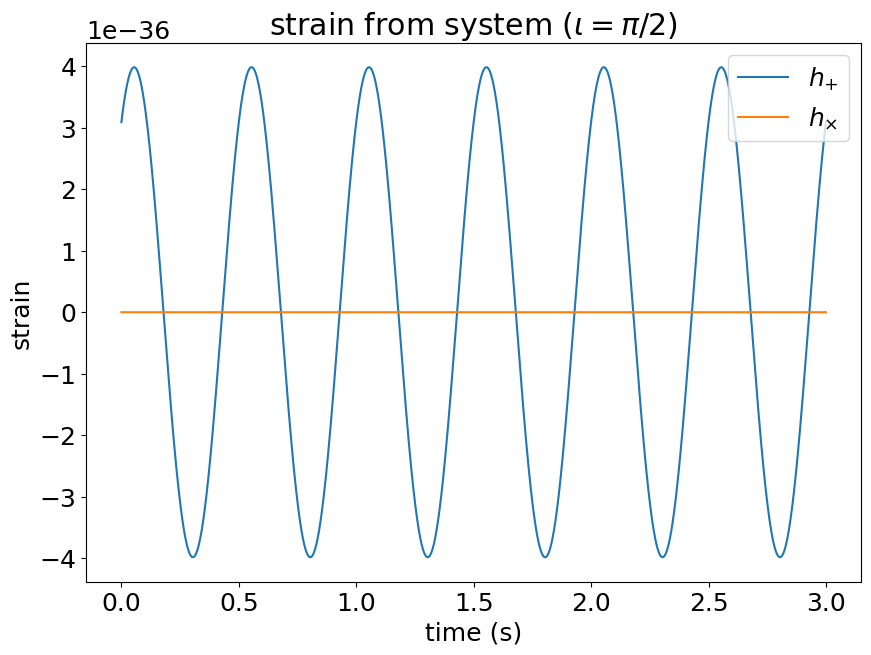

In [28]:
# Viewing angle
iota2 = (np.pi/2) * u.rad

# List of plus polarized strains
hPlus2 = h0 * (1/2) * (1 + np.cos(iota2)**2) * np.cos(2 * Omega * (ts - r/co.c))
# List of cross polarized strains
hCross2 = h0 * np.cos(iota2) * np.sin(2 * Omega * (ts - r/co.c))

# Creating figure
plt.figure(figsize=(10, 7))
# Plotting strains
plt.plot(ts, hPlus2, label='$h_{+}$')
plt.plot(ts, hCross2, label=r'$h_{\times}$')
# Adding axes labels
plt.xlabel('time (s)'); plt.ylabel('strain')
# Adding figure title
plt.title('strain from system ($\iota = \pi/2$)')
plt.legend(loc='upper right')
plt.show()

Here there is no cross polarized strain anymore! Moreover, the plus polarized strain is decreased by a factor of two, down to $4\times{10^{-36}}$.

Finally, we can look at a value between the two, say a colatitude of $\pi/4$.

h+ amplitude: 5.98e-36
hx amplitude: 5.64e-36


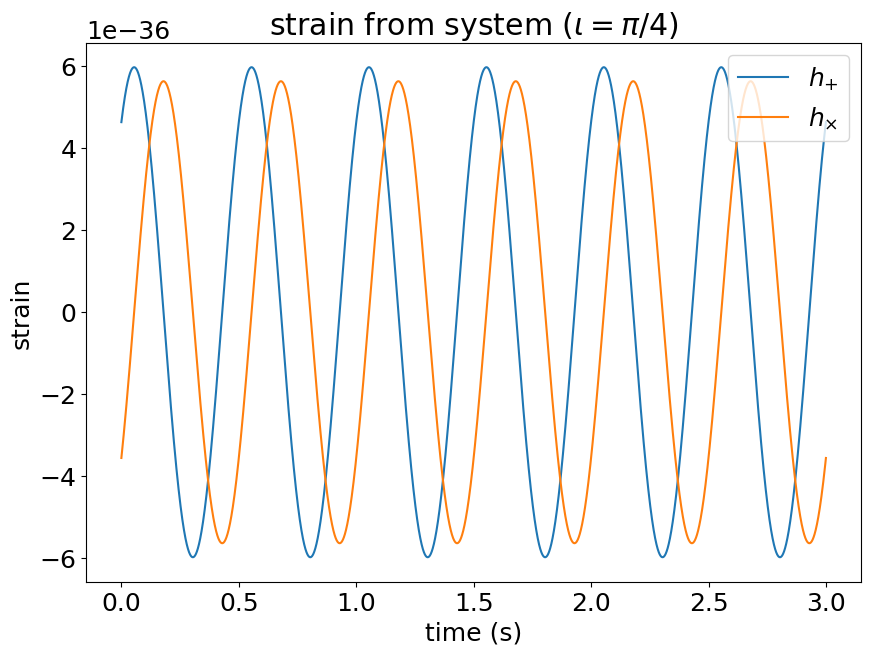

In [29]:
# Viewing angle
iota3 = (np.pi/4) * u.rad

# Amplitudes of strain polarizations
hp3 = h0 * (1/2) * (1 + np.cos(iota3)**2); hc3 = h0 * np.cos(iota3)
# List of plus polarized strains
hPlus3 = hp3 * np.cos(2 * Omega * (ts - r/co.c))
# List of cross polarized strains
hCross3 = hc3 * np.sin(2 * Omega * (ts - r/co.c))

print(f'h+ amplitude: {hp3:.3g}\nhx amplitude: {hc3:.3g}')

# Creating figure
plt.figure(figsize=(10, 7))
# Plotting strains
plt.plot(ts, hPlus3, label='$h_{+}$')
plt.plot(ts, hCross3, label=r'$h_{\times}$')
# Adding axes labels
plt.xlabel('time (s)'); plt.ylabel('strain')
# Adding figure title
plt.title('strain from system ($\iota = \pi/4$)')
plt.legend(loc='upper right')
plt.show()

Here there are components of both polarizations, but the plus polarized is slightly larger at an amplitude of $6\times{10^{-36}}$ than the cross polarized at an amplitude of $5.6\times{10^{-36}}$.

To see the trend, we can see how these amplitudes change as a function of viewing angle.

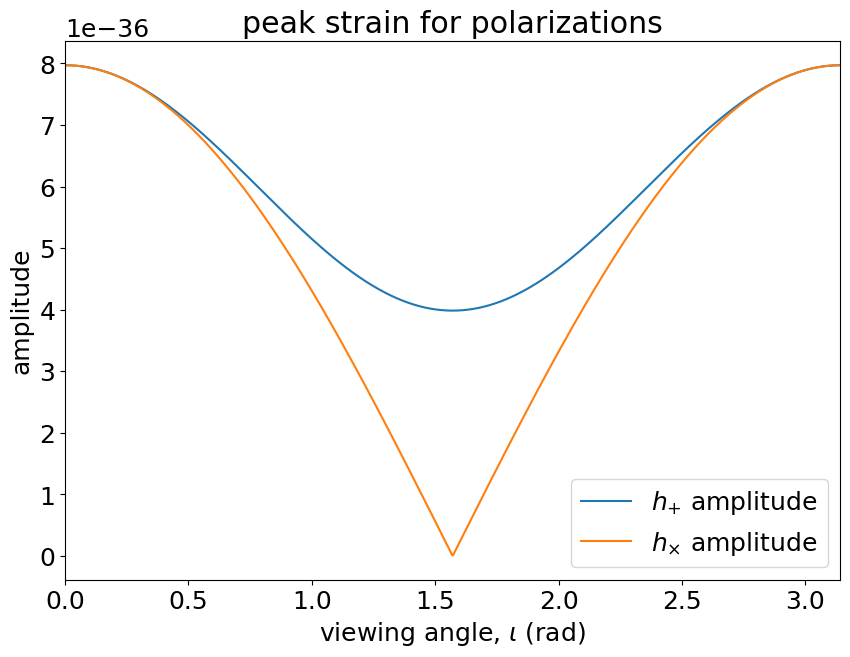

In [30]:
# Array of viewing angles
iotas = np.linspace(0, np.pi, num=int(1e3)) * u.rad

# List of plus polarized strains
hps = h0 * (1/2) * (1 + np.cos(iotas)**2)
# List of cross polarized strains
hcs = np.abs(h0 * np.cos(iotas))

# Creating figure
plt.figure(figsize=(10, 7))
# Plotting strains
plt.plot(iotas, hps, label='$h_{+}$ amplitude')
plt.plot(iotas, hcs, label=r'$h_{\times}$ amplitude')
# Adding axes labels
plt.xlabel('viewing angle, $\iota$ (rad)'); plt.ylabel('amplitude')
# Adding figure title
plt.title('peak strain for polarizations')
plt.legend(loc='lower right')
plt.xlim(0, np.pi); plt.show()

So the viewing angle that produces the largest strain is along the axis of rotation! Moreover, is it possible to see that the amplitude of the plus polarization falls to one half as we get closer the viewing along the equator, while the cross polarization falls to zero instead. Both are also symmetric about the equator.

A value that would be interesting to look at is how much power is being lost through these gravitational waves.

The following formula by Hartle gives the luminosity of a source in the  transverse-traceless gauge [6].

$L_{\text{GW}} = \dfrac{1}{5} \dfrac{G}{c^5} \langle \dddot{\mathbf{I}}_{ij} \dddot{\mathbf{I}}^{ij}\rangle$

(Since $\ddot{\mathbf{I}}$ is transverse traceless, $\ddot{\mathcal{I}} = \ddot{\textbf{I}}$)

So, we can find the third time derivative of the inertia tensor. Note that this is computed at $t = t$ since it is being computed at the source.

$\dddot{\mathbf{I}} =  4 \left(m_{1} a_{1}^2 + m_{2} a_{2}^2 \right) \Omega^3
\begin{bmatrix}
-\sin{2 \Omega t} & \cos{2 \Omega t} & 0 \\
\cos{2 \Omega t} & \sin{2 \Omega t} & 0 \\
0 & 0 & 0 \\
\end{bmatrix}$

Next, we compute the following,

$\dddot{\mathbf{I}}_{ij} \dddot{\mathbf{I}}^{ij} = 16 \left(m_{1} a_{1}^2 + m_{2} a_{2}^{2}\right)^2 \Omega^{6} \left(\cos^2{2 \Omega t} + \cos^2{2 \Omega t}\right)$

$= 32 \left(m_{1} a_{1}^2 + m_{2} a_{2}^{2}\right)^2 \Omega^{6} \cos^2{2 \Omega t}$

Next we will take the time-average of this expression over a cycle.

$\langle \dddot{\mathbf{I}}_{ij} \dddot{\mathbf{I}}^{ij}\rangle = 16 \left(m_{1} a_{1}^2 + m_{2} a_{2}^{2}\right)^2 \Omega^{6}$

Finally, we can plug this into the formula for gravitational wave luminosity.

$\boxed{L_{\text{GW}} = \dfrac{16}{5} \dfrac{G \left(m_{1} a_{1}^2 + m_{2} a_{2}^{2}\right)^2 \Omega^{6}}{c^5}}$

This is a complicated formula, so let's double-check the units on it.

In [31]:
# Units of L_GW
uLGW = (co.G.si * ((u.kg * u.m * u.m)**2) * ((1/u.s)**6) / ((u.m/u.s)**5)).unit
uLGW

Unit("kg m2 / s3")

These are the required units for power. Now we can calculate this value for our system.

In [32]:
LGW = ((16/5)*co.G*(L0**2)*((Omega/u.rad)**6)/(co.c**5)).si

print(f'Gravitational wave luminosity: {LGW:.3g}')

Gravitational wave luminosity: 0.193 J / s


So the luminosity in gravitational waves is $0.2~\text{W}$. This value is tiny! A typical AA battery can provide a peak current of $2~\text{A}$ at $1.5~\text{V}$ or a power of about $3~\text{W}$. This is sixteen times the power being emitted by the neutron star in gravitational waves.

As for where this energy comes from, there are two possibilities. If we assume that the neutron star is rigid and unchanging, this energy would come from the rotational kinetic energy. So $\Omega$ would decrease as a function of time. There would also be mass lost as energy but this would be negligibly small since we are far below relativistic speeds. The surface of the neutron star is only rotating at $6.3\times{10^4}~\text{m}/\text{s}$ which is $5\,000$ times smaller than the speed of light.

The other scenario is where the surface of the neutron star is malleable. In this case the mountain would get smaller over time, losing gravitational potential energy being converted mostly to rotational kinetic energy but with a small fraction being lost as gravitational waves. In this case, the neutron star would spin up and have a tiny chirp, similar to a merging binary.

Just for fun let's consider graviational waves from Olympus Mons on Mars. I will consider it to be on the equator and equated to a sphere again.

In [33]:
# Distance to mars from earth at closest approach
r = (1.524-1) * u.AU
# Period of neutron star rotation
tau = 1*u.d + 37*u.min
# Density of mars
rho = 3934 * (u.kg/(u.m**3))
# Radius of mars, Height of mountain
R1 = 3389.5 * u.km; R2 = 25 * u.km

# Mass of neutron star; Mass of mountain
m1 = ((4/3)*np.pi*rho*R1**3).to(u.kg); m2 = ((4/3)*np.pi*rho*R2**3).to(u.kg)
# Total mass, reduced mass
M = m1 + m2; mu = (m1*m2/M)
# Distance between centers of mars and olympus mons
Rsum = (R1 + R2).to(u.m)
# Center of mass of star-mountain
xbar = ((m1*0 * u.m + m2*Rsum)/M).to(u.m)
# Distance of neutron star from center, Distance of mountain from center of mass
a1 = xbar; a2 = Rsum - xbar

In [34]:
# Rotation frequency of neutron star
f = 1/tau; Omega = 2*np.pi*f * u.rad
# Start and end times
tStart = 0; tEnd = 3*(tau.to(u.s).value) # seconds
# Creating array of times
ts = np.linspace(tStart, tEnd, num=int(1e4)) * u.s
# Mars center coordinates,  Mountain center coordinates
x1 = a1*np.cos(Omega * ts); y1 = a1*np.sin(Omega * ts)
x2 = -a2*np.cos(Omega * ts); y2 = -a2*np.sin(Omega * ts)

# Moment of inertia constant
L0 = m1 * (a1**2) + m2 * (a2**2)
# Amplitude of strain
h0 = ((4 * co.G * L0 * (Omega/u.rad)**2)/((co.c**4) * r)).decompose()

print(f'Amplitude of strain: {h0:.3g}')

Amplitude of strain: 6.36e-33


So the amplitude is about $1\,000$ times larger than for the neutron star, but still below LIGO's strain sensitivity of $10^{-22}$. Moreover, we would be detecting very close to within the plane of rotation of Mars so $\iota \simeq \pi/2$.

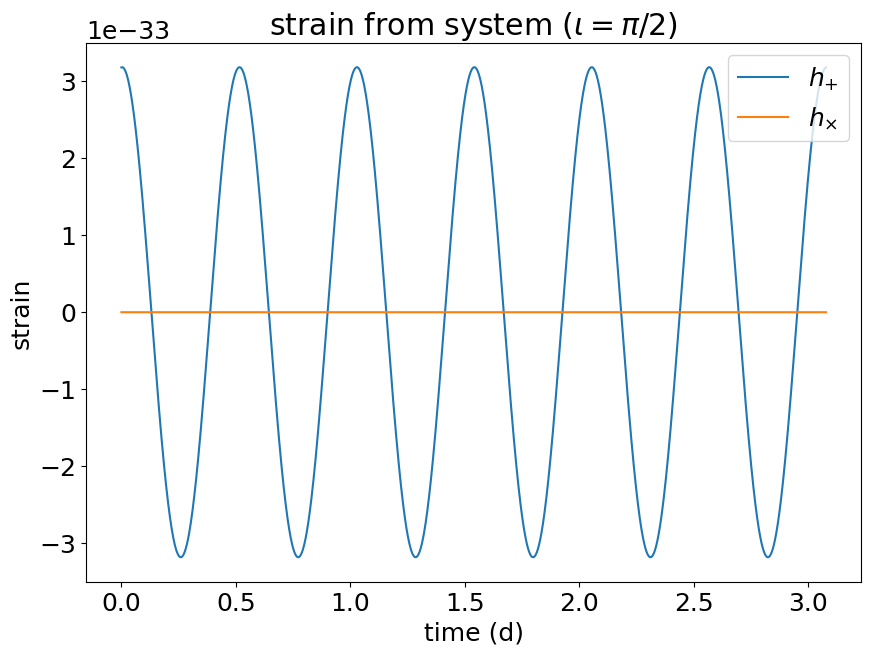

In [35]:
# Viewing angle
iota2 = (np.pi/2) * u.rad
# List of plus polarized strains
hPlus2 = h0 * (1/2) * (1 + np.cos(iota2)**2) * np.cos(2 * Omega * (ts - r/co.c))
# List of cross polarized strains
hCross2 = h0 * np.cos(iota2) * np.sin(2 * Omega * (ts - r/co.c))
# Creating figure
plt.figure(figsize=(10, 7))
# Plotting strains
plt.plot(ts.to(u.d), hPlus2, label='$h_{+}$')
plt.plot(ts.to(u.d), hCross2, label=r'$h_{\times}$')
# Adding axes labels
plt.xlabel('time (d)'); plt.ylabel('strain')
# Adding figure title
plt.title('strain from system ($\iota = \pi/2$)')
plt.legend(loc='upper right')
plt.show()

So there is no $h_{\times}$ term and $h_{+}$ oscillates at twice of period of rotation of Mars, with an amplitude around $3\times{10^{-33}}$. Next, we can look at the gravitational wave luminosity.

In [36]:
LGW = ((16/5)*co.G*(L0**2)*((Omega/u.rad)**6)/(co.c**5)).si

print(f'Gravitational wave luminosity: {LGW:.3g}')

Gravitational wave luminosity: 1.01e-16 J / s


So Mars has a luminosity (only due to Olympus Mons) of only $1\times{10^{-16}}~\text{W}$ which is absolutely miniscule. This is because it has a period much smaller than our neutron star and luminosity grows as frequency to the sixth power.

## Acknowledgements

I would like to acknowledge the guidance of professor Jeremy Darling, and many useful discussions with my friends.

## References

[1] "What Are Gravitational Waves?" Caltech. Accessed December 4, 2022. https://www.ligo.caltech.edu/page/what-are-gw. 

[2] "Event List." GWOSC. Accessed December 4, 2022. https://www.gw-openscience.org/eventapi/html/GWTC/.

[3] "Neutron Star." Wikipedia. Wikimedia Foundation, November 29, 2022. https://en.wikipedia.org/wiki/Neutron_star.

[4] Dhurandhar, Sanjeev, and Sanjit Mitra. General Relativity and Gravitational Waves: Essentials of Theory and Practice. Cham: Springer, 2022.

[5] Winicour, Jeffrey. "The Quadrupole Radiation Formula." General Relativity and Gravitation 19, no. 3 (March 1987): 281–87. https://doi.org/10.1007/BF00761722.

[6] Hartle, James B. Gravity : An Introduction to Einstein’s General Relativity. Gravity / James B. Hartle. San Francisco, 2003. https://ui.adsabs.harvard.edu/abs/2003gieg.book.....H.